In [1]:
import time
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset, Subset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from LSTM import LSTMModel  # uses LSTM.py

In [2]:
# Load cleaned data from CSV
input_path = "world_bank_data_clean.csv"
world_bank_data = pd.read_csv(input_path)

In [3]:
# Selecting features and target variable
numeric_cols = [col for col in world_bank_data.columns 
               if col not in ['country', 'date', 'year']]

target_col = 'GDPpc_2017$'  # We forecast GDP per capita for the next 5 years

In [4]:
# Preprocessing data as windows
input_window = 10
output_window = 5

RANDOM_STATE = 42

# To enforce true consecutive years
ENFORCE_CONSECUTIVE_YEARS = True

def is_consecutive(years: np.ndarray) -> bool:
    return np.all(np.diff(years) == 1)

# Build windows X, y (+ country labels for stratification)
X, y, countries_win, end_year_win, start_year_win = [], [], [], [], []

for country in world_bank_data["country"].unique():
    df = (world_bank_data[world_bank_data["country"] == country]
          .sort_values("year")
          .reset_index(drop=True))

    years = df["year"].to_numpy()

    for i in range(len(df) - input_window - output_window + 1):
        in_years  = years[i : i + input_window]
        out_years = years[i + input_window : i + input_window + output_window]

        if ENFORCE_CONSECUTIVE_YEARS:
            if (not is_consecutive(in_years)) or (not is_consecutive(out_years)) or (out_years[0] != in_years[-1] + 1):
                continue

        X_win = df.iloc[i : i + input_window][numeric_cols].to_numpy()
        y_win = df.iloc[i + input_window : i + input_window + output_window][target_col].to_numpy()  # (5,)

        X.append(X_win)
        y.append(y_win)
        countries_win.append(country)
        start_year_win.append(in_years[0])
        end_year_win.append(out_years[-1])  # key for "how far into the future" this sample goes

X = np.array(X)                    # (n_samples, 10, 10)
y = np.array(y)                    # (n_samples, 5)
countries_win = np.array(countries_win)  # (n_samples,)
start_year_win = np.array(start_year_win) # (n_samples,)
end_year_win = np.array(end_year_win) # (n_samples,)

print("Built windows:")
print("X:", X.shape, "y:", y.shape, "countries_win:", countries_win.shape, "start_year_win:", start_year_win.shape, "end_year_win:", end_year_win.shape)

Built windows:
X: (6570, 10, 10) y: (6570, 5) countries_win: (6570,) start_year_win: (6570,) end_year_win: (6570,)


In [5]:
# Build concatenated flattened sequences: (n_samples, 105)
# X: (n, 10, 10), y: (n, 5)
X_flat = X.reshape(X.shape[0], -1)          # (n, 100)
Z = np.concatenate([X_flat, y], axis=1)     # (n, 105)

print("Z (concat):", Z.shape)

Z (concat): (6570, 105)


In [6]:
# Scaling Z for VAE stability
scaler_vae = StandardScaler()
scaler_vae.fit(Z)

Z_scaled = scaler_vae.transform(Z).astype(np.float32)

In [7]:
# Torch Dataset / Loader
device = torch.device("cuda")

Z_tensor = torch.tensor(Z_scaled, dtype=torch.float32)

n = len(Z_tensor)
n_train = int(0.9 * n)
train_ds = TensorDataset(Z_tensor[:n_train])
val_ds   = TensorDataset(Z_tensor[n_train:])

batch_size = 256
train_loader_vae = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader_vae   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)

print("Train batches:", len(train_loader_vae), "Val batches:", len(val_loader_vae))

Train batches: 24 Val batches: 3


In [8]:
# VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=105, hidden_dims=(256, 128), latent_dim=16, dropout=0.1):
        super().__init__()
        h1, h2 = hidden_dims

        # Encoder
        self.enc = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h1, h2),
            nn.ReLU(),
        )
        self.mu     = nn.Linear(h2, latent_dim)
        self.logvar = nn.Linear(h2, latent_dim)

        # Decoder
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, h2),
            nn.ReLU(),
            nn.Linear(h2, h1),
            nn.ReLU(),
            nn.Linear(h1, input_dim),
        )

    def encode(self, x):
        h = self.enc(x)
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.dec(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [9]:
# Loss: Recon + KL, and ELBO logging
def vae_loss(x, x_hat, mu, logvar, beta=1.0):
    # Reconstruction loss (MSE)
    recon = F.mse_loss(x_hat, x, reduction="mean")

    # KL divergence: D_KL(q(z|x) || p(z)) where p(z)=N(0,I)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # Negative ELBO to minimize
    loss = recon + beta * kl

    # ELBO (higher is better): ELBO = -(recon + kl) up to constants; we log a comparable value
    elbo = -(recon + kl)

    return loss, recon, kl, elbo

In [10]:
# Train VAE
def train_vae(model, train_loader, val_loader, epochs=100, lr=1e-3, weight_decay=1e-5, beta=1.0):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    hist = {
        "train_loss": [], "train_recon": [], "train_kl": [], "train_elbo": [],
        "val_loss":   [], "val_recon":   [], "val_kl":   [], "val_elbo":   [],
    }

    for epoch in range(1, epochs+1):
        t0 = time.perf_counter()

        # Train
        model.train()
        tl = tr = tk = te = 0.0
        n = 0
        for (xb,) in train_loader:
            xb = xb.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)

            x_hat, mu, logvar = model(xb)
            loss, recon, kl, elbo = vae_loss(xb, x_hat, mu, logvar, beta=beta)

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            bs = xb.size(0)
            tl += loss.item() * bs
            tr += recon.item() * bs
            tk += kl.item() * bs
            te += elbo.item() * bs
            n  += bs

        hist["train_loss"].append(tl/n)
        hist["train_recon"].append(tr/n)
        hist["train_kl"].append(tk/n)
        hist["train_elbo"].append(te/n)

        # Val
        model.eval()
        vl = vr = vk = ve = 0.0
        nv = 0
        with torch.no_grad():
            for (xb,) in val_loader:
                xb = xb.to(device, non_blocking=True)
                x_hat, mu, logvar = model(xb)
                loss, recon, kl, elbo = vae_loss(xb, x_hat, mu, logvar, beta=beta)

                bs = xb.size(0)
                vl += loss.item() * bs
                vr += recon.item() * bs
                vk += kl.item() * bs
                ve += elbo.item() * bs
                nv += bs

        hist["val_loss"].append(vl/nv)
        hist["val_recon"].append(vr/nv)
        hist["val_kl"].append(vk/nv)
        hist["val_elbo"].append(ve/nv)

        t1 = time.perf_counter()
        if epoch == 1 or epoch % 10 == 0:
            print(
                f"Epoch {epoch:03d} | "
                f"train loss={hist['train_loss'][-1]:.4f} (recon={hist['train_recon'][-1]:.4f}, kl={hist['train_kl'][-1]:.4f}, elbo={hist['train_elbo'][-1]:.4f}) | "
                f"val loss={hist['val_loss'][-1]:.4f} (recon={hist['val_recon'][-1]:.4f}, kl={hist['val_kl'][-1]:.4f}, elbo={hist['val_elbo'][-1]:.4f}) | "
                f"{(t1-t0):.2f}s"
            )

    return hist

vae = VAE(input_dim=105, hidden_dims=(256, 128), latent_dim=16, dropout=0.1)
hist = train_vae(vae, train_loader_vae, val_loader_vae, epochs=100, lr=1e-3, weight_decay=1e-5, beta=1.0)

Epoch 001 | train loss=1.0214 (recon=1.0176, kl=0.0037, elbo=-1.0214) | val loss=0.8331 (recon=0.8218, kl=0.0114, elbo=-0.8331) | 0.85s
Epoch 010 | train loss=0.5825 (recon=0.4097, kl=0.1727, elbo=-0.5825) | val loss=0.5250 (recon=0.3772, kl=0.1477, elbo=-0.5250) | 0.53s
Epoch 020 | train loss=0.5285 (recon=0.3315, kl=0.1970, elbo=-0.5285) | val loss=0.4912 (recon=0.3191, kl=0.1721, elbo=-0.4912) | 0.36s
Epoch 030 | train loss=0.5061 (recon=0.3021, kl=0.2039, elbo=-0.5061) | val loss=0.5004 (recon=0.3293, kl=0.1711, elbo=-0.5004) | 0.27s
Epoch 040 | train loss=0.4961 (recon=0.2903, kl=0.2057, elbo=-0.4961) | val loss=0.4935 (recon=0.3189, kl=0.1746, elbo=-0.4935) | 0.31s
Epoch 050 | train loss=0.4851 (recon=0.2775, kl=0.2076, elbo=-0.4851) | val loss=0.4956 (recon=0.3213, kl=0.1743, elbo=-0.4956) | 0.38s
Epoch 060 | train loss=0.4851 (recon=0.2749, kl=0.2102, elbo=-0.4851) | val loss=0.4934 (recon=0.3246, kl=0.1688, elbo=-0.4934) | 0.30s
Epoch 070 | train loss=0.4820 (recon=0.2704, kl=

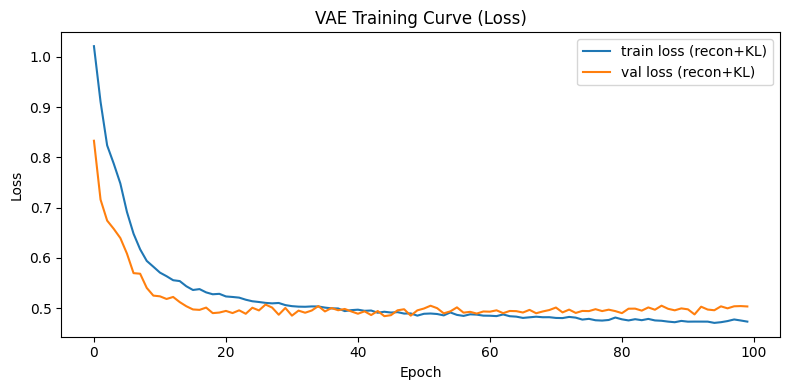

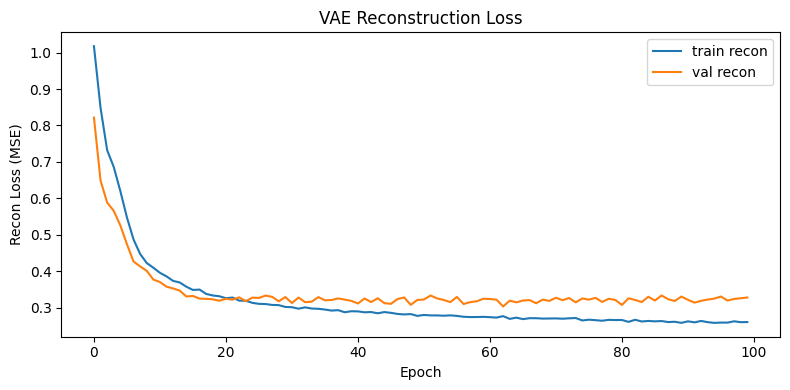

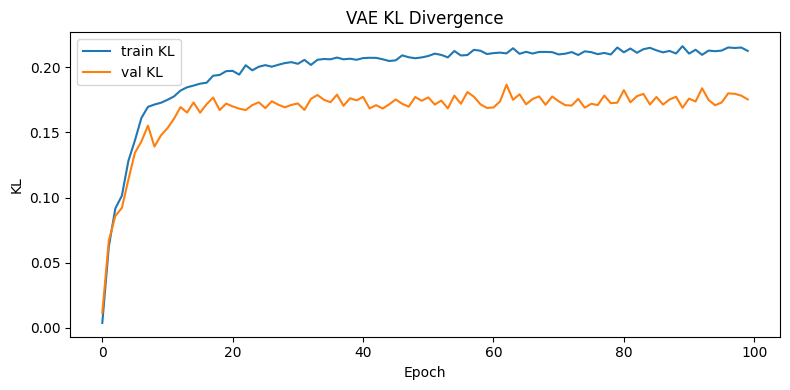

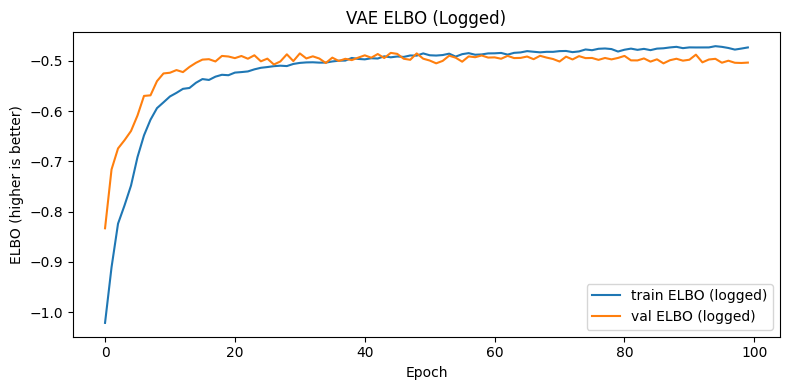

In [11]:
# Learning curves: recon, KL, loss, ELBO
plt.figure(figsize=(8,4))
plt.plot(hist["train_loss"], label="train loss (recon+KL)")
plt.plot(hist["val_loss"], label="val loss (recon+KL)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Curve (Loss)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(hist["train_recon"], label="train recon")
plt.plot(hist["val_recon"], label="val recon")
plt.xlabel("Epoch")
plt.ylabel("Recon Loss (MSE)")
plt.title("VAE Reconstruction Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(hist["train_kl"], label="train KL")
plt.plot(hist["val_kl"], label="val KL")
plt.xlabel("Epoch")
plt.ylabel("KL")
plt.title("VAE KL Divergence")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(hist["train_elbo"], label="train ELBO (logged)")
plt.plot(hist["val_elbo"], label="val ELBO (logged)")
plt.xlabel("Epoch")
plt.ylabel("ELBO (higher is better)")
plt.title("VAE ELBO (Logged)")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Extract latent representations and run t-SNE (3D)
@torch.no_grad()
def extract_latents_mu(model, Z_tensor, batch_size=1024):
    model.eval()
    mus = []
    loader = DataLoader(TensorDataset(Z_tensor), batch_size=batch_size, shuffle=False)
    for (xb,) in loader:
        xb = xb.to(device, non_blocking=True)
        mu, logvar = model.encode(xb)
        mus.append(mu.detach().cpu().numpy())
    return np.concatenate(mus, axis=0)

latent_mu = extract_latents_mu(vae, Z_tensor)   # (n_samples, latent_dim)
print("Latent mu:", latent_mu.shape)

tsne = TSNE(
    n_components=3,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42,
)
latent_3d = tsne.fit_transform(latent_mu)
print("t-SNE 3D:", latent_3d.shape)

Latent mu: (6570, 16)
t-SNE 3D: (6570, 3)


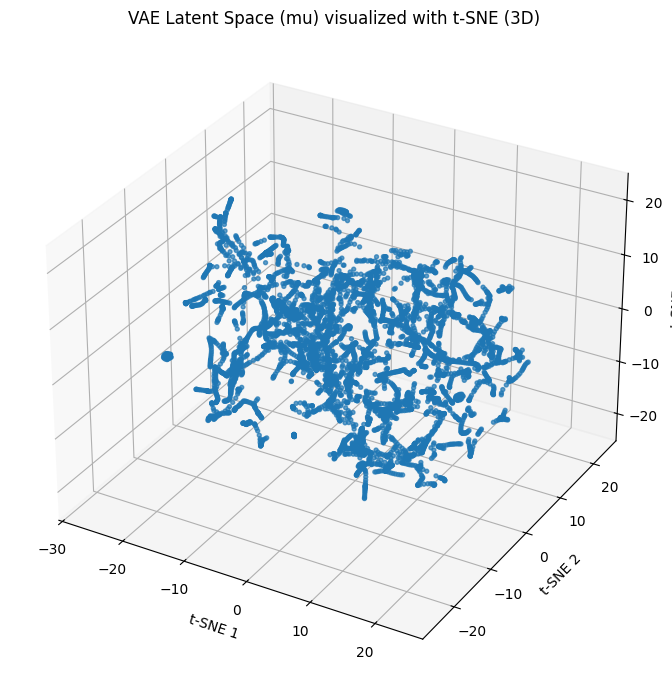

In [13]:
# 3D scatter plot of t-SNE latent space
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], s=8, alpha=0.7)
ax.set_title("VAE Latent Space (mu) visualized with t-SNE (3D)")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
plt.tight_layout()
plt.show()

In [14]:
# Helper functions for training best model (LSTM)
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

def align_output_and_target(out: torch.Tensor, y: torch.Tensor):
    # Handles (B,H,1) -> (B,H)
    if out.dim() == 3 and out.size(-1) == 1:
        out = out.squeeze(-1)
    if y.dim() == 3 and y.size(-1) == 1:
        y = y.squeeze(-1)
    if out.shape != y.shape:
        raise ValueError(f"Shape mismatch: pred {tuple(out.shape)} vs target {tuple(y.shape)}")
    return out, y

@torch.no_grad()
def predict_loader(model, loader):
    model.eval()
    preds, trues = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        out = model(xb)
        out, yb = align_output_and_target(out, yb)
        preds.append(out.detach().cpu())
        trues.append(yb.detach().cpu())
    return torch.cat(preds, dim=0), torch.cat(trues, dim=0)

def regression_metrics(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=np.float64).reshape(-1)
    y_pred = np.asarray(y_pred, dtype=np.float64).reshape(-1)
    mse = np.mean((y_pred - y_true) ** 2)
    mae = np.mean(np.abs(y_pred - y_true))
    denom = np.maximum(np.abs(y_true), eps)
    mape = np.mean(np.abs((y_pred - y_true) / denom)) * 100.0
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2) + eps
    r2 = 1.0 - (ss_res / ss_tot)
    return {"mse": mse, "mae": mae, "mape": mape, "r2": r2}

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total = 0.0
    n = 0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        out = model(xb)
        out, yb = align_output_and_target(out, yb)

        loss = criterion(out, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        bs = xb.size(0)
        total += loss.item() * bs
        n += bs
    return total / max(n, 1)

In [15]:
# Windows and train test split
input_window = 10
output_window = 5

# out_start_year for each window = first output year = start_year + input_window
out_start_year_win = start_year_win + input_window

# time-aware 80/20 by end_year_win
order = np.argsort(end_year_win)
n = len(order)
n_train = int(0.8 * n)

train_idx = order[:n_train]
test_idx  = order[n_train:]

print("Train windows:", len(train_idx), "Test windows:", len(test_idx))
print("Train end_year max:", end_year_win[train_idx].max(), "| Test end_year min:", end_year_win[test_idx].min())

Train windows: 5256 Test windows: 1314
Train end_year max: 2017 | Test end_year min: 2018


In [16]:
# Fit X scaler on real train only
scaler_X_aug = StandardScaler()
X_train_real_flat = X[train_idx].reshape(len(train_idx), -1)  # (n_train, 100)
scaler_X_aug.fit(X_train_real_flat)

# Fit y scaler on real train only
scaler_y_aug = StandardScaler()
y_train_real_flat = y[train_idx].reshape(-1, 1)              # (n_train*H, 1)
scaler_y_aug.fit(y_train_real_flat)

def transform_Xy(X_in, y_in):
    Xf = X_in.reshape(X_in.shape[0], -1)
    Xs = scaler_X_aug.transform(Xf).reshape(X_in.shape).astype(np.float32)
    ys = scaler_y_aug.transform(y_in.reshape(-1, 1)).reshape(y_in.shape).astype(np.float32)
    return Xs, ys

In [17]:
# Generate synthetic samples
n_synth = int(0.4 * len(train_idx))  # 40% of train size
latent_dim = vae.mu.out_features     # latent size from VAE

vae.eval()

with torch.no_grad():
    z = torch.randn(n_synth, latent_dim, device=device)
    Z_synth_scaled = vae.decode(z).detach().cpu().numpy().astype(np.float32)  # (n_synth, 105)

# Inverse VAE scaling back to original units (features+target)
Z_synth_raw = scaler_vae.inverse_transform(Z_synth_scaled)  # (n_synth, 105)

# Split into X_synth_raw (100) and y_synth_raw (5)
n_feat = X.shape[2]  # number_of_features (10)
X_synth_raw = Z_synth_raw[:, :input_window * n_feat].reshape(n_synth, input_window, n_feat)
y_synth_raw = Z_synth_raw[:, input_window * n_feat:].reshape(n_synth, output_window)

# Scale for LSTM using scalers fit on REAL train
X_synth_s, y_synth_s = transform_Xy(X_synth_raw, y_synth_raw)

print("Synthetic X:", X_synth_s.shape, "Synthetic y:", y_synth_s.shape)

Synthetic X: (2102, 10, 10) Synthetic y: (2102, 5)


In [18]:
# Sample out_start_years for synthetic windows from REAL train windows
synth_ref_idx = np.random.choice(train_idx, size=n_synth, replace=True)
out_start_year_synth = out_start_year_win[synth_ref_idx]  # (n_synth,)

In [19]:
# Real train scaled
X_train_s, y_train_s = transform_Xy(X[train_idx], y[train_idx])
# Real test scaled
X_test_s,  y_test_s  = transform_Xy(X[test_idx],  y[test_idx])

# Convert to tensors
X_train_tensor = torch.tensor(X_train_s, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_s, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_s,  dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_s,  dtype=torch.float32)

X_synth_tensor = torch.tensor(X_synth_s, dtype=torch.float32)
y_synth_tensor = torch.tensor(y_synth_s, dtype=torch.float32)

# Augmented training dataset = real train + synthetic
train_aug_dataset = ConcatDataset([
    TensorDataset(X_train_tensor, y_train_tensor),
    TensorDataset(X_synth_tensor, y_synth_tensor)
])

train_aug_loader = DataLoader(train_aug_dataset, batch_size=256, shuffle=True, drop_last=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=256, shuffle=False, drop_last=False)

print("Train_aug samples:", len(train_aug_dataset), "Test samples:", len(X_test_tensor))

Train_aug samples: 7358 Test samples: 1314


In [20]:
# Train our best model (LSTM) with Augmented data from VAE
best_hp = {
    "hidden_size": 256,
    "num_layers": 1,
    "dropout": 0.1,
    "lr": 0.003,
    "weight_decay": 1e-06
}

input_size = X.shape[2]
output_size = y.shape[1]

model = LSTMModel(
    input_size=input_size,
    hidden_size=best_hp["hidden_size"],
    num_layers=best_hp["num_layers"],
    dropout=best_hp["dropout"],
    output_size=output_size,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=best_hp["lr"],
    weight_decay=best_hp["weight_decay"]
)

EPOCHS = 50

train_loss_curve = []

# Train
for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_aug_loader, optimizer, criterion)
    train_loss_curve.append(tr_loss)
    print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss(scaled MSE)={tr_loss:.6f}")

# Train evaluation
train_pred_s, train_true_s = predict_loader(model, train_aug_loader)
train_pred = scaler_y_aug.inverse_transform(train_pred_s.numpy().reshape(-1,1)).reshape(train_pred_s.shape)
train_true = scaler_y_aug.inverse_transform(train_true_s.numpy().reshape(-1,1)).reshape(train_true_s.shape)
train_metrics_real = regression_metrics(train_true, train_pred)

print("\nFINAL TRAIN metrics (REAL units):", train_metrics_real)

# Test evaluation
test_pred_s, test_true_s = predict_loader(model, test_loader)
test_pred = scaler_y_aug.inverse_transform(test_pred_s.numpy().reshape(-1,1)).reshape(test_pred_s.shape)
test_true = scaler_y_aug.inverse_transform(test_true_s.numpy().reshape(-1,1)).reshape(test_true_s.shape)
test_metrics_real = regression_metrics(test_true, test_pred)

print("FINAL TEST metrics (REAL units):", test_metrics_real)

Epoch 01/50 | train_loss(scaled MSE)=0.265946
Epoch 02/50 | train_loss(scaled MSE)=0.100196
Epoch 03/50 | train_loss(scaled MSE)=0.068727
Epoch 04/50 | train_loss(scaled MSE)=0.062264
Epoch 05/50 | train_loss(scaled MSE)=0.058961
Epoch 06/50 | train_loss(scaled MSE)=0.061429
Epoch 07/50 | train_loss(scaled MSE)=0.052285
Epoch 08/50 | train_loss(scaled MSE)=0.050811
Epoch 09/50 | train_loss(scaled MSE)=0.048651
Epoch 10/50 | train_loss(scaled MSE)=0.046834
Epoch 11/50 | train_loss(scaled MSE)=0.047592
Epoch 12/50 | train_loss(scaled MSE)=0.050255
Epoch 13/50 | train_loss(scaled MSE)=0.046708
Epoch 14/50 | train_loss(scaled MSE)=0.045909
Epoch 15/50 | train_loss(scaled MSE)=0.043593
Epoch 16/50 | train_loss(scaled MSE)=0.043667
Epoch 17/50 | train_loss(scaled MSE)=0.043334
Epoch 18/50 | train_loss(scaled MSE)=0.041251
Epoch 19/50 | train_loss(scaled MSE)=0.039477
Epoch 20/50 | train_loss(scaled MSE)=0.042235
Epoch 21/50 | train_loss(scaled MSE)=0.040374
Epoch 22/50 | train_loss(scaled MS

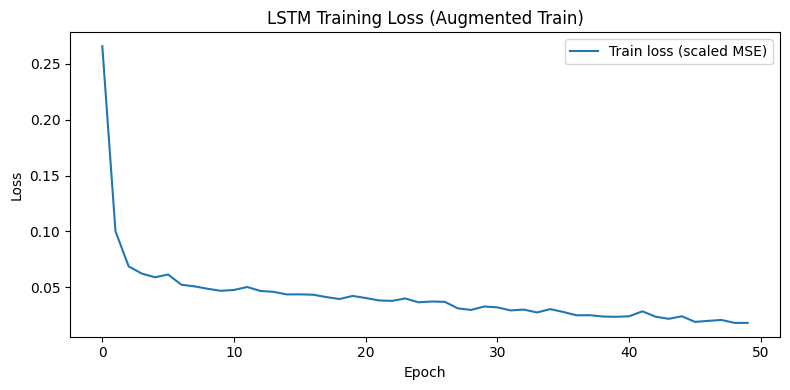

In [21]:
# Plot the learning curve
plt.figure(figsize=(8,4))
plt.plot(train_loss_curve, label="Train loss (scaled MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM Training Loss (Augmented Train)")
plt.legend()
plt.tight_layout()
plt.show()

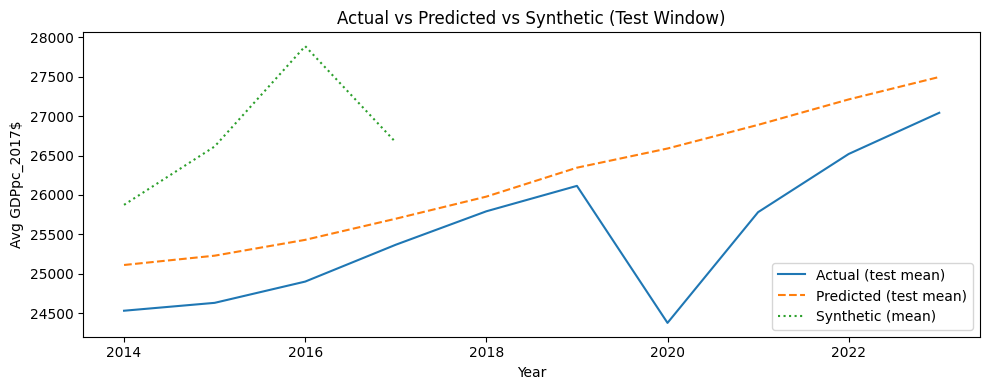

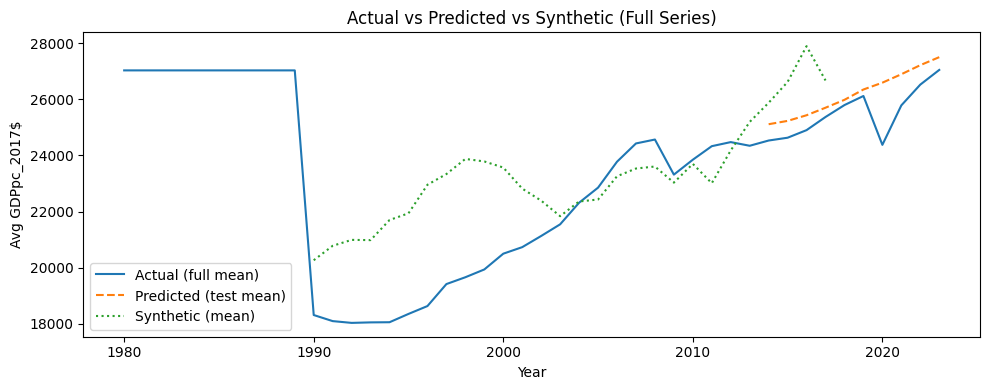

In [22]:
# Plot actual vs synthetic vs forecasted
def plot_actual_pred_synth_two_charts_simple(
    y_true_test, y_pred_test,                  # (n_test, H) REAL units
    out_start_year_test,                       # (n_test,)
    y_synth=None, out_start_year_synth=None,   # (n_synth, H) REAL units + (n_synth,)
    output_window=5,
    world_bank_data=None,
    start_year_actual=1980,
    target_col="GDPpc_2017$",
    limit_synth_to_test_years_plot1=True,
):
    # Aggregate test actual/pred by year
    years_test = np.asarray(out_start_year_test)[:, None] + np.arange(output_window)
    years_flat = years_test.ravel()

    true_flat = np.asarray(y_true_test).ravel()
    pred_flat = np.asarray(y_pred_test).ravel()

    uniq_years, inv = np.unique(years_flat, return_inverse=True)
    cnt = np.bincount(inv)
    true_year = np.bincount(inv, weights=true_flat) / cnt
    pred_year = np.bincount(inv, weights=pred_flat) / cnt

    # Aggregate synthetic by year
    synth_years_all, synth_vals_all = None, None
    synth_years_plot1, synth_vals_plot1 = None, None

    if y_synth is not None and out_start_year_synth is not None:
        years_s = np.asarray(out_start_year_synth)[:, None] + np.arange(output_window)
        ys_flat = years_s.ravel()
        synth_flat = np.asarray(y_synth).ravel()

        uniq_s, inv_s = np.unique(ys_flat, return_inverse=True)
        cnt_s = np.bincount(inv_s)
        synth_year = np.bincount(inv_s, weights=synth_flat) / cnt_s

        # Store full synthetic curve
        synth_years_all, synth_vals_all = uniq_s, synth_year

        # Clip synthetic curve
        if limit_synth_to_test_years_plot1:
            lo, hi = uniq_years.min(), uniq_years.max()
            mask = (uniq_s >= lo) & (uniq_s <= hi)
            synth_years_plot1 = uniq_s[mask]
            synth_vals_plot1  = synth_year[mask]
        else:
            synth_years_plot1, synth_vals_plot1 = uniq_s, synth_year

    # Full actual series
    if world_bank_data is not None:
        actual_by_year = (
            world_bank_data[world_bank_data["year"] >= start_year_actual]
            .groupby("year")[target_col].mean().sort_index()
        )
        all_years = actual_by_year.index.to_numpy()
        actual_all = actual_by_year.to_numpy()
    else:
        all_years, actual_all = None, None

    # Plot test window only
    plt.figure(figsize=(10, 4))
    plt.plot(uniq_years, true_year, label="Actual (test mean)")
    plt.plot(uniq_years, pred_year, linestyle="--", label="Predicted (test mean)")
    if synth_years_plot1 is not None and len(synth_years_plot1) > 0:
        plt.plot(synth_years_plot1, synth_vals_plot1, linestyle=":", label="Synthetic (mean)")
    plt.xlabel("Year")
    plt.ylabel(f"Avg {target_col}")
    plt.title("Actual vs Predicted vs Synthetic (Test Window)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot full series + predicted tail
    plt.figure(figsize=(10, 4))
    if all_years is not None:
        plt.plot(all_years, actual_all, label="Actual (full mean)")
    plt.plot(uniq_years, pred_year, linestyle="--", label="Predicted (test mean)")
    if synth_years_all is not None and len(synth_years_all) > 0:
        plt.plot(synth_years_all, synth_vals_all, linestyle=":", label="Synthetic (mean)")
    plt.xlabel("Year")
    plt.ylabel(f"Avg {target_col}")
    plt.title("Actual vs Predicted vs Synthetic (Full Series)")
    plt.legend()
    plt.tight_layout()
    plt.show()

y_synth_s = y_synth_tensor.detach().cpu().numpy()
y_synth_real = scaler_y_aug.inverse_transform(y_synth_s.reshape(-1, 1)).reshape(y_synth_s.shape)

plot_actual_pred_synth_two_charts_simple(
    y_true_test=test_true,
    y_pred_test=test_pred,
    out_start_year_test=out_start_year_win[test_idx],
    y_synth=y_synth_real,
    out_start_year_synth=out_start_year_synth,
    output_window=output_window,
    world_bank_data=world_bank_data
)